# Conditional MNIST example

In the last notebook we looked at the creation of handwritten digits. However we could not control which numbers where generated because we had no idea how the GAN mapped the different digits from 0-9 in the latent space. In this tutorial where forcing the network to learn a specific distribution for every digit such that we have control over the output when generating new examples. Note that this comes at a cost: While so far all examples where performed in an unsupervised way (menaing you didn't use the labels of the data) this approach needs labeled data.

First import the usual libraries:

In [1]:
import os
import torch
import pickle

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

os.chdir("/home/thomas/Backup/Algorithmen/GAN-pytorch")
from vegans.GAN import ConditionalWassersteinGAN, ConditionalWassersteinGANGP
from vegans.utils.utils import plot_losses, plot_images, get_input_dim

Check if your machine has an available GPU for usage.

In [2]:
print('Cuda is available: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda is available: True


Now download the mnist dataset and set the parameters below (To get exactly the same format as in this tutorial download from [here](https://github.com/tneuer/GAN-pytorch/tree/main/data/mnist), but of course you can load it from anywhere you want):

In [3]:
# This directory should contain "train_images.pickle and test_images.pickle"
datapath_train = "/home/thomas/Backup/Algorithmen/GAN-pytorch/data/mnist/train_images.pickle"
datapath_test = "/home/thomas/Backup/Algorithmen/GAN-pytorch/data/mnist/test_images.pickle"

# Hidden layer channels for generator / critic
ngf = 8
ncf = 4

# Padding for mnist images (28x28) -> (32x32)
pad = 2

Now load and preprocess the data:
- The images are saved in gray scale from 0-255, so we scale it to 0-1. Then we can use a Sigmoid as the last layer of the generator.
- The original image shape is (28, 28) but when working with convolutional layers it is often beneficial to have a power of two. Therefore we pad two empty rows and columns to every image.
- Finally we reshape the images because we need the images in the shape of (nr_channels, nr_heiht_pixels, nr_width_pixels). In out case this results in [1, 32, 32]

In [4]:
""" Create dataset
"""
with open(datapath_train, "rb") as f:
    X_train, y_train = pickle.load(f)

with open(datapath_test, "rb") as f:
    X_test, y_test = pickle.load(f)
    
X_train = X_train / np.max(X_train)
X_test = X_test / np.max(X_test)
X_train = np.pad(X_train, [(0, 0), (pad, pad), (pad, pad)], mode='constant').reshape(-1, 1, 32, 32)
X_test = np.pad(X_test, [(0, 0), (pad, pad), (pad, pad)], mode='constant').reshape(-1, 1, 32, 32)
print(X_train.shape, X_test.shape)

(60000, 1, 32, 32) (10000, 1, 32, 32)


Now we plot the handwritten digits, this time using the labels because we anyway need them later for this supervised algortihm.

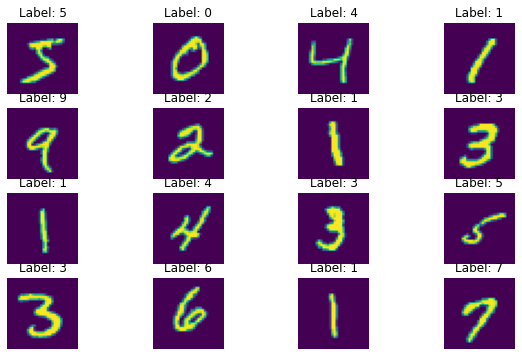

In [5]:
fig, axs = plot_images(images=X_train.reshape(-1, 32, 32), labels=y_train, n=16)

We need to pass the labels as one hot encoded vectors so we use the scikit-learn library to transform the data.

In [6]:
one_hot_encoder = OneHotEncoder(sparse=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))
print(y_train.shape, y_test.shape)

(60000, 10) (10000, 10)


We now define all the different input sizes for the discriminator and generator. Note that internally the images X_train are concatenated with the labels before passing them to the discriminator / critic. The labels are also concatenated with the noise so that the generator as well as the adversariat can learn to differentiate between images of different digits. To calculate the number of input channels / features we can use a utility functiion called `get_input_dim(dim1, dim2)`.

In [7]:
x_dim = X_train.shape[1:]
y_dim = y_train.shape[1:]
z_dim = [1, 4, 4]

print("x_dim:", x_dim, "y_dim:", y_dim, "z_dim:", z_dim)
adv_in_dim = get_input_dim(dim1=x_dim, dim2=y_dim)
gen_in_dim = get_input_dim(dim1=z_dim, dim2=y_dim)
print("Adv_dim:", adv_in_dim, "Gen_dim:", gen_in_dim)

x_dim: (1, 32, 32) y_dim: (10,) z_dim: [1, 4, 4]
Adv_dim: [11, 32, 32] Gen_dim: [11, 4, 4]


Note that the labels get concatenated with the channel axis of both the `z_dim` and `x_dim`. You could choose for `z_dim` a single integer as well and it would return the correct amount of features.

### Definition of Generator and Discriminator / Critic
We'll specify the architecture of the generator and discriminator / critic networks. It's difficult to know which architectures to choose before training. Here we used a architecture which proved to work.

Since we want to train a Wasserstein GAN, the output of the critic should be a real number and not a probability. Therefore we drop the last sigmoid and use the identity function. If you want to switch to a architecture that uses a discriminator switch the `nn.Identity` with `nn.Sigmoid` for the adversariat.

In [9]:
""" Generator
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        ngf = 20
        nc = 1
        self.hidden_part = nn.Sequential(
            nn.ConvTranspose2d(in_channels=gen_in_dim[0], out_channels=ngf * 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.1),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.1),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.1),
            nn.Conv2d(ngf * 2, ngf * 2, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.1),
            nn.Conv2d(ngf, ngf, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 5, 1, 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nc, nc, kernel_size=3, stride=1, padding=1),
        )
        self.output = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
""" Adversariat
"""
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        
        ncf = 8
        self.hidden_part = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(in_channels=adv_in_dim[0], out_channels=ncf, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf) x 16 x 16
            nn.Conv2d(ncf, ncf * 2, 4, 2, 1),
            nn.BatchNorm2d(ncf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf*2) x 8 x 8
            nn.Conv2d(ncf * 2, ncf * 4, 4, 2, 1),
            nn.BatchNorm2d(ncf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf*4) x 4 x 4
            nn.Conv2d(ncf * 4, ncf * 8, 4, 2, 1),
            nn.BatchNorm2d(ncf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ncf*8) x 2 x 2
            nn.Flatten(),
            nn.Linear(in_features=ncf*8*2*2, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1)
        )
        self.output = nn.Identity()

    def forward(self, x):
        x = self.hidden_part(x)
        x = self.output(x)
        return x
    
generator = Generator()
critic = Critic()

### Train our GAN
Build a Wasserstein GAN trainer, using default optimizers (we can also specify our own). To use a different GAN algorithm, just use the corresponding class (e.g., `VanillaGAN` for original GAN).

Here you can specify some optional GAN parameters, such as the latent space dimension `z_dim`, the number of samples to save (`fixed_noise_size`) and the optimizer keyword arguments (`optim_kwargs`). We set `folder=None` so that no folder is created where all results would be stored. Otherwise we could give a path like `folder="TrainedModels/GAN"`. All results (summary, images, loss functions, tensorboard information, models) would be saved in that folder. You can control what should be saved in the `fit` method. This folder will never overwrite an existing folder. If the path already exists a new path of the form `folder=path_{TimeStamp}` is created.

We also decrease the learning rate of the critic a little.
For this conditional algorithm we also need to pass in the dimension of the one hot encoded labels.

In [12]:
optim_kwargs = {"Generator": {"lr": 0.0005}, "Adversariat": {"lr": 0.0001}}
gan = ConditionalWassersteinGAN(
    generator, critic, z_dim=z_dim, x_dim=x_dim, y_dim=y_dim,
    optim_kwargs=optim_kwargs, fixed_noise_size=20, folder=None
)

In [13]:
gan.summary()

Generator
Input shape:  (11, 4, 4)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 160, 4, 4]          16,000
       BatchNorm2d-2            [-1, 160, 4, 4]             320
         LeakyReLU-3            [-1, 160, 4, 4]               0
   ConvTranspose2d-4             [-1, 80, 8, 8]         204,880
       BatchNorm2d-5             [-1, 80, 8, 8]             160
         LeakyReLU-6             [-1, 80, 8, 8]               0
   ConvTranspose2d-7           [-1, 40, 16, 16]          51,240
       BatchNorm2d-8           [-1, 40, 16, 16]              80
         LeakyReLU-9           [-1, 40, 16, 16]               0
           Conv2d-10           [-1, 40, 16, 16]          14,440
      BatchNorm2d-11           [-1, 40, 16, 16]              80
        LeakyReLU-12           [-1, 40, 16, 16]               0
  ConvTranspose2d-13           [-1, 20, 32, 32]          12,820
    

Train the networks by calling the `fit()` method. Here you can specify some parameters for training like `eochs`, `batch_size`, `save_model_every`, `save_images_every`, `print_every`, `enable_tensorboard` and others.

You can interrupt training at any time and still access train stats from within the `gan` object. You can resume training later. Note that we increase the number of steps the critic (adversariat) is trained, which is common for Wasserstein GANs but not VanillaGANs so take care when switching out algorithms.

In [14]:
steps = {"Adversariat": 5}
gan.fit(
    X_train, y_train, X_test, y_test, epochs=5, steps=steps,
    print_every="0.25e", save_losses_every=10, enable_tensorboard=False
)

------------------------------------------------------------
EPOCH: 1
------------------------------------------------------------
Step: 468 / 9375 (Epoch: 1 / 5, Batch: 468 / 1875)
------------------------------------------------------------
Generator: 0.008447149768471718
Adversariat: 1.896452158689499e-05
Adversariat_fake: -0.008447149768471718
Adversariat_real: 0.008485078811645508
RealFakeRatio: -1.0044901371002197


Time left: ~14.863 minutes (Steps remaining: 8907).


Step: 936 / 9375 (Epoch: 1 / 5, Batch: 936 / 1875)
------------------------------------------------------------
Generator: 0.006292358972132206
Adversariat: -0.00021411944180727005
Adversariat_fake: -0.006292358972132206
Adversariat_real: 0.005864120088517666
RealFakeRatio: -0.9319430589675903


Time left: ~13.936 minutes (Steps remaining: 8439).


Step: 1404 / 9375 (Epoch: 1 / 5, Batch: 1404 / 1875)
------------------------------------------------------------
Generator: 0.007013081107288599
Adversariat: -0.0005701

Investigate the results and loss curves.

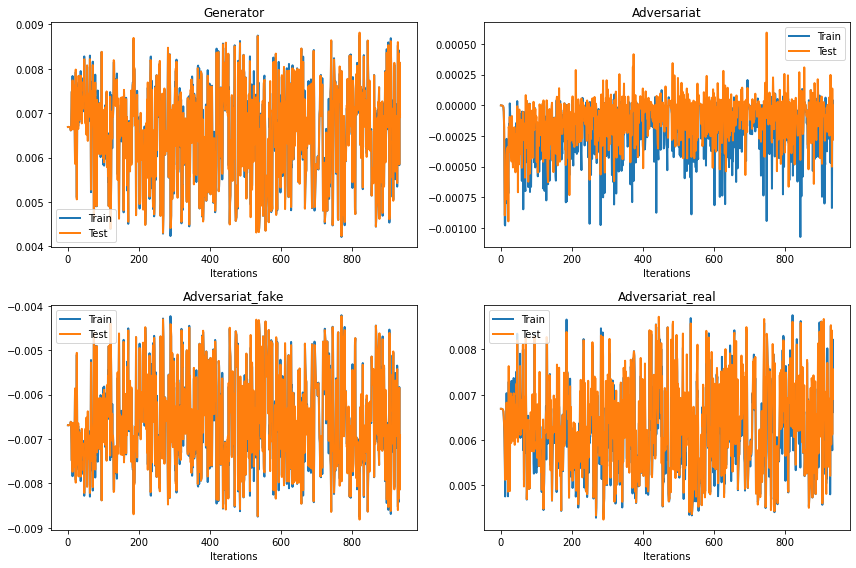

(20, 1, 32, 32)


In [15]:
samples, losses = gan.get_training_results()
fig, axs = plot_losses(losses)
print(samples.shape)

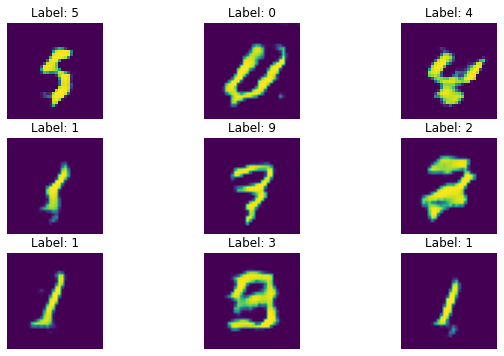

In [16]:
fixed_labels = np.argmax(gan.fixed_labels.cpu().detach().numpy(), axis=1)
fig, axs = plot_images(samples.reshape(-1, 32, 32), n=9, labels=fixed_labels)

Now we want to generate new images and have control over the number of generated images. Note that the `get_training_results` returns as many images as were specified with the `fixed_noise_size` argument in the constructor when creating the GAN.

In [17]:
my_labels = np.zeros(shape=(10, 10))
np.fill_diagonal(my_labels, 1)
new_samples = gan.generate(y=my_labels)
print(new_samples.shape)
fig, axs = plot_images(samples.reshape(-1, 32, 32), labels=list(range(10)))

TypeError: reshape(): argument 'input' (position 1) must be Tensor, not numpy.ndarray